In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [139]:
train_data, test_data = pd.read_csv('train.csv'), pd.read_csv('test.csv')

In [141]:
train_data.drop(train_data[train_data['made']==10000].index, inplace=True)
train_data.drop(train_data[train_data['floors']==6000].index, inplace=True)
train_data.drop(train_data[train_data['garage']>1000].index, inplace=True)
train_data.drop(train_data[train_data['squareMeters']>100000].index, inplace=True)
train_data.drop(train_data[train_data['basement']>10000].index, inplace=True)
train_data.drop(train_data[train_data['attic']>10000].index, inplace=True)

In [142]:
train_data['age'] = 2022-train_data['made']
train_data.drop('made', axis=1, inplace=True)

test_data['age'] = 2022-test_data['made']
test_data.drop('made', axis=1, inplace=True)

#### Analysis

In [52]:
train_data.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,age
0,0,34291,24,1,0,47,35693,2,1,0,1,8,5196,369,0,3,3436795.2,22
1,1,95145,60,0,1,60,34773,1,4,0,1,729,4496,277,0,6,9519958.0,22
2,2,92661,45,1,1,62,45457,4,8,1,1,7473,8953,245,1,9,9276448.1,2
3,3,97184,99,0,0,59,15113,1,1,0,1,6424,8522,256,1,9,9725732.2,22
4,4,61752,100,0,0,57,64245,8,4,1,0,7151,2786,863,0,7,6181908.8,4


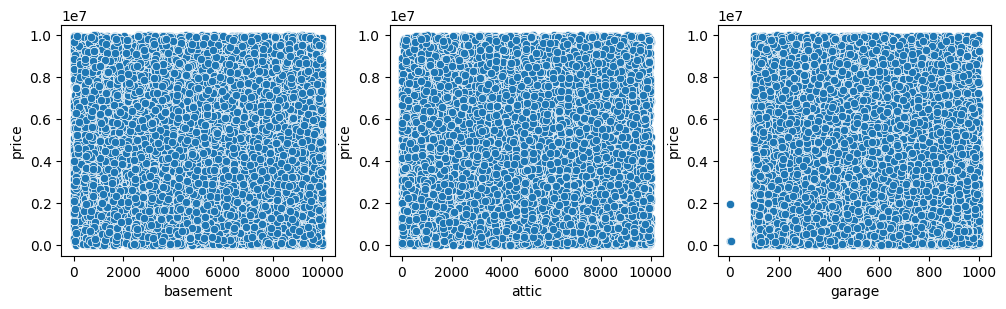

In [53]:
columns = ['basement','attic','garage']
plt.figure(figsize=(12,3))
for i in range(len(columns)):
    plt.subplot(1,3,i+1)
    sns.scatterplot(data=train_data, x=columns[i], y='price')

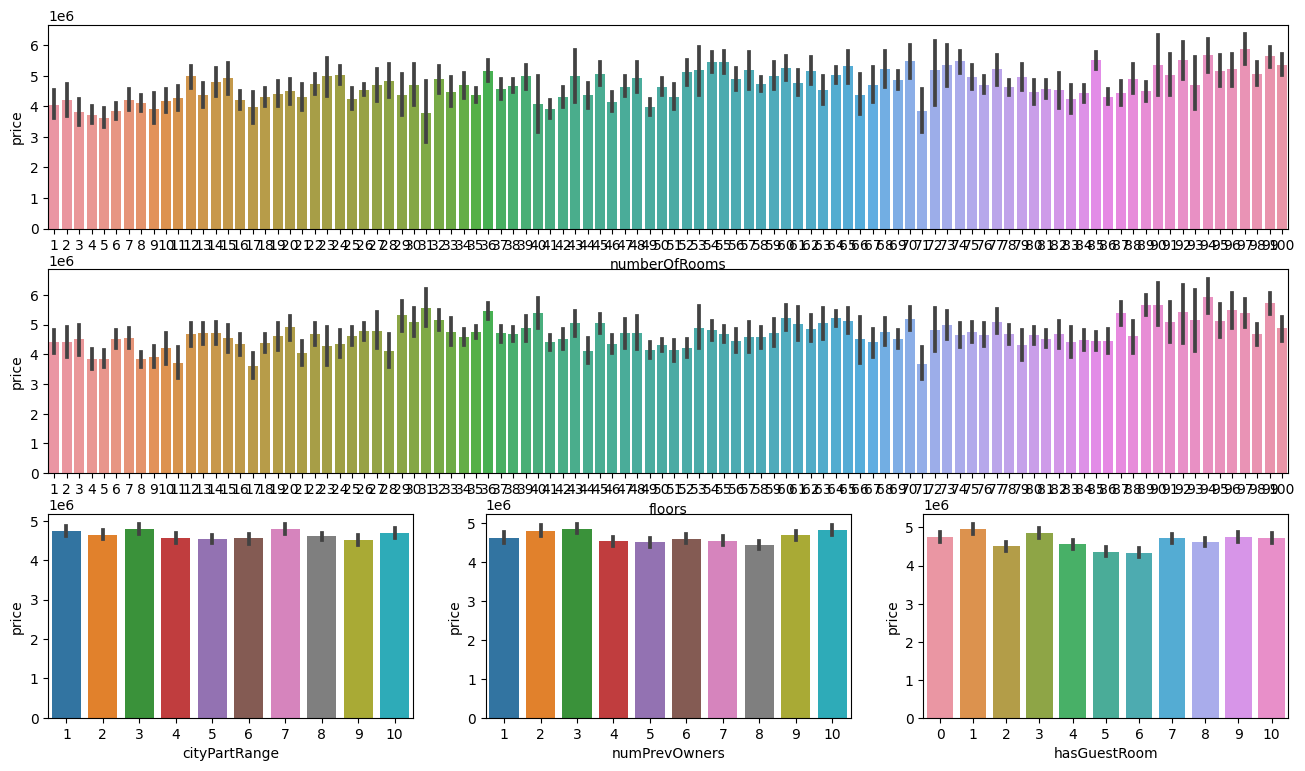

In [44]:
columns = ['cityPartRange','numPrevOwners','hasGuestRoom'] #'numberOfRooms','floors'
plt.figure(figsize=(16,9))
plt.subplot(3,1,1)
sns.barplot(data=train_data, x='numberOfRooms', y='price')
plt.subplot(3,1,2)
sns.barplot(data=train_data, x='floors', y='price')
for i in range(len(columns)):
    plt.subplot(3,3,i+7)
    sns.barplot(data=train_data, x=columns[i], y='price')

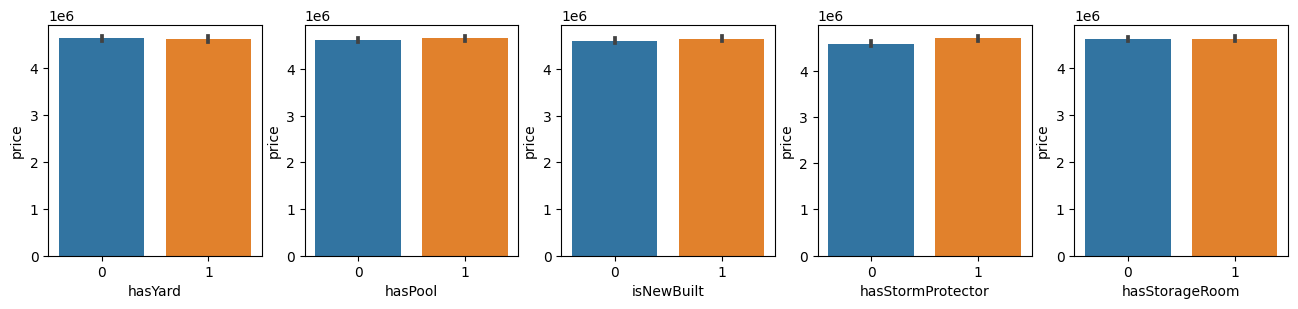

In [34]:
columns = ['hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom']
plt.figure(figsize=(16,3))
for i in range(len(columns)):
    plt.subplot(1,5,i+1)
    sns.barplot(data=train_data, x=columns[i], y='price')

#### squareMeters

In [143]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(train_data['squareMeters'].values.reshape(-1,1), train_data['price'].values)

m = linreg.coef_
c = linreg.intercept_

xline = range(100000)
yline = (m*xline) + c

In [144]:
train_data['distance'] = abs((m*train_data['squareMeters'])-train_data['price']+c)/math.sqrt((m**2)+1)

<AxesSubplot: xlabel='squareMeters', ylabel='price'>

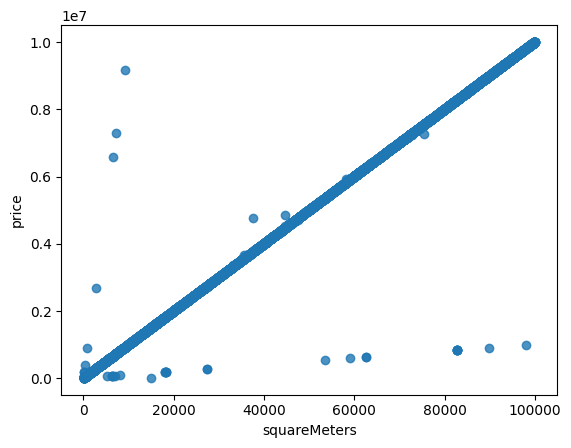

In [146]:
sns.regplot(data=train_data, x='squareMeters', y='price')
#sns.scatterplot(data=train_data, x='squareMeters', y='price', c=['blue' if x else 'green' for x in train_data['distance']<10000])
#plt.plot(xline,yline,c='red')

In [11]:
#train_data.drop(train_data[train_data['distance']>10000].index, inplace=True)

#### Getting ready for model

In [126]:
train_data['roomsPerFloor'] = train_data['numberOfRooms']/train_data['floors']
test_data['roomsPerFloor'] = test_data['numberOfRooms']/test_data['floors']

In [127]:
columns = ['squareMeters','age','cityPartRange','numPrevOwners','roomsPerFloor','hasGuestRoom','basement','attic','garage','hasYard','hasPool','isNewBuilt','hasStormProtector','hasStorageRoom','numberOfRooms','floors']
y = train_data['price']

x = train_data[columns]
x = pd.get_dummies(x, columns=['numPrevOwners'])
x_test = test_data[columns]
x_test = pd.get_dummies(x_test, columns=['numPrevOwners'])

In [128]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [137]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=0.1,random_state=42)

In [138]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, early_stopping_rounds=5)
xgb.fit(x_train,y_train,eval_set=[(x_val,y_val)])

[0]	validation_0-rmse:3866300.87654
[1]	validation_0-rmse:2708609.96670
[2]	validation_0-rmse:1899148.74506
[3]	validation_0-rmse:1332356.19848
[4]	validation_0-rmse:936656.66004
[5]	validation_0-rmse:660273.20408
[6]	validation_0-rmse:469014.77658
[7]	validation_0-rmse:337476.80863
[8]	validation_0-rmse:248480.57384
[9]	validation_0-rmse:184346.93240
[10]	validation_0-rmse:138654.61722
[11]	validation_0-rmse:115126.08547
[12]	validation_0-rmse:93547.22356
[13]	validation_0-rmse:77669.03368
[14]	validation_0-rmse:72902.06650
[15]	validation_0-rmse:70833.58831
[16]	validation_0-rmse:69508.08355
[17]	validation_0-rmse:72150.47641
[18]	validation_0-rmse:71762.77086
[19]	validation_0-rmse:71559.05071
[20]	validation_0-rmse:71374.27187


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [131]:
result = xgb.predict(x_test)

In [132]:
df = pd.DataFrame({'id':test_data['id'].values, 'price':result})
df.to_csv('submission.csv', index=False)